In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## KNN

In [ ]:
import numpy as np
import time
import resource
from collections import Counter
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import cupy as cp

# --- Load MNIST ---
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(np.int64)

# Normalize to [0, 1]
X = X / 255.0

# Split into train/test
X_train_np, X_test_np, y_train, y_test = train_test_split(X, y, train_size=1000, test_size=100, stratify=y, random_state=42)


In [ ]:
# import torch
# print(torch.cuda.get_device_name(0))
# print(torch.cuda.memory_allocated() / 1024**2, "MB used")

#### 1. CuPy: Numpy on GPU

In [ ]:
# --- Move to GPU ---
X_train = cp.asarray(X_train_np, dtype=cp.float32)
X_test = cp.asarray(X_test_np, dtype=cp.float32)

# --- Euclidean distance ---
def euclidean_distance_gpu(a, b):
    return cp.sqrt(cp.sum((a - b)**2, axis=1))

# --- KNN Logic on GPU ---
def knn_cupy(X_train, y_train, X_test, k=5):
    predictions = []
    for i in range(X_test.shape[0]):
        dists = euclidean_distance_gpu(X_train, X_test[i])
        nearest = cp.asnumpy(cp.argsort(dists)[:k])
        nearest_labels = y_train[nearest]
        predictions.append(Counter(nearest_labels).most_common(1)[0][0])
    return np.array(predictions)

# --- GPU Memory Report ---
def print_gpu_memory_usage():
    mempool = cp.get_default_memory_pool()
    pinned = cp.get_default_pinned_memory_pool()
    used = mempool.used_bytes() / (1024 ** 2)
    total = mempool.total_bytes() / (1024 ** 2)
    print(f"[CuPy] GPU Memory Used: {used:.2f} MB")
    print(f"[CuPy] GPU Memory Allocated (Total): {total:.2f} MB")

# --- Bandwidth Estimator ---
def test_bandwidth_cupy(X_train, X_test):
    cp.cuda.Device().synchronize()
    start = time.time()
    _ = cp.sum((X_train - X_test[0])**2, axis=1)
    cp.cuda.Device().synchronize()
    end = time.time()

    bytes_moved = (X_train.nbytes + X_test[0].nbytes) * 2
    bandwidth = bytes_moved / (end - start) / 1e9
    print(f"[CuPy] Estimated Memory Bandwidth: {bandwidth:.2f} GB/s")

# --- Run Benchmark ---
start = time.time()
y_pred = knn_cupy(X_train, y_train, X_test)
cp.cuda.Device().synchronize()
end = time.time()

accuracy = np.mean(y_pred == y_test)
print(f"KNN-CuPy Accuracy (MNIST): {accuracy:.2f}")
print(f"Execution Time: {end - start:.4f} seconds")

# --- Report Extras ---
print_gpu_memory_usage()
test_bandwidth_cupy(X_train, X_test)

KNN-CuPy Accuracy (MNIST): 0.96
Execution Time: 1.0316 seconds
[CuPy] GPU Memory Used: 3.29 MB
[CuPy] GPU Memory Allocated (Total): 12.26 MB
[CuPy] Estimated Memory Bandwidth: 12.19 GB/s


#### 2. PyTorch

In [ ]:
import torch
import time
from collections import Counter
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# --- Load MNIST ---
mnist = fetch_openml(data_id=554, as_frame=False)  # Stable ID for MNIST
X, y = mnist["data"], mnist["target"].astype(int)

# Normalize and split
X = X / 255.0
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X, y, train_size=1000, test_size=100, stratify=y, random_state=42
)

# --- Move to GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train_np, dtype=torch.int64, device=device)
X_test = torch.tensor(X_test_np, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test_np, dtype=torch.int64, device=device)

# --- Euclidean distance ---
def euclidean_distance(a, b):
    return torch.sqrt(torch.sum((a - b) ** 2, dim=1))  # on GPU

# --- KNN Logic on GPU (same as CPU logic) ---
def knn_torch_gpu(X_train, y_train, X_test, k=5):
    predictions = []
    for i in range(X_test.shape[0]):
        test_point = X_test[i]
        distances = euclidean_distance(X_train, test_point)
        nearest = torch.topk(distances, k=k, largest=False).indices
        nearest_labels = y_train[nearest]
        predicted = torch.mode(nearest_labels).values.item()
        predictions.append(predicted)
    return torch.tensor(predictions, device='cpu')

# --- GPU Memory Usage ---
def print_gpu_memory_usage():
    torch.cuda.synchronize()
    allocated = torch.cuda.memory_allocated() / 1024**2
    reserved = torch.cuda.memory_reserved() / 1024**2
    print(f"[PyTorch GPU] Memory Allocated: {allocated:.2f} MB")
    print(f"[PyTorch GPU] Memory Reserved:  {reserved:.2f} MB")

# --- Memory Bandwidth ---
def test_bandwidth_torch_gpu(X_train, X_test):
    torch.cuda.synchronize()
    start = time.time()
    _ = torch.sum((X_train - X_test[0]) ** 2, dim=1)
    torch.cuda.synchronize()
    end = time.time()

    bytes_moved = (X_train.element_size() * X_train.nelement() +
                   X_test[0].element_size() * X_test[0].nelement()) * 2
    bandwidth = bytes_moved / (end - start) / 1e9
    print(f"[PyTorch GPU] Estimated Memory Bandwidth: {bandwidth:.2f} GB/s")

# --- Benchmark ---
torch.cuda.synchronize()
start = time.time()
y_pred = knn_torch_gpu(X_train, y_train, X_test, k=5)
torch.cuda.synchronize()
end = time.time()

print(f"Device: {device}")

accuracy = (y_pred == y_test.cpu()).float().mean().item()
print(f"KNN-PyTorch (GPU) Accuracy: {accuracy:.2f}")
print(f"Execution Time: {end - start:.4f} seconds")

print_gpu_memory_usage()
test_bandwidth_torch_gpu(X_train, X_test)


Device: cuda
KNN-PyTorch (GPU) Accuracy: 0.96
Execution Time: 0.3248 seconds
[PyTorch GPU] Memory Allocated: 3.30 MB
[PyTorch GPU] Memory Reserved:  22.00 MB
[PyTorch GPU] Estimated Memory Bandwidth: 36.12 GB/s


#### 3. C++

In [1]:
## another document

## Image Preprocessing Pipelines

#### 1. Numpy

In [ ]:
## kaggle

#### 2. PyTorch

In [ ]:
!pip install torch torchvision pynvml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 363.4/363.4 MB 131.8 MB/s eta 0:00:01
ERROR: Operation cancelled by user


Found 2 image(s) in: /content/gdrive/MyDrive/Colab Notebooks/MSML605 Project/images



Processed 2 image(s)
Total Execution Time: 2.5820 seconds
Estimated Memory Bandwidth: 0.022 GB/s
Peak RAM Usage: 2503.69 MB
GPU Memory Used: 437.88 MB
GPU Memory Total: 15360.00 MB


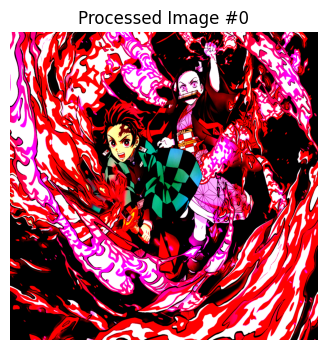

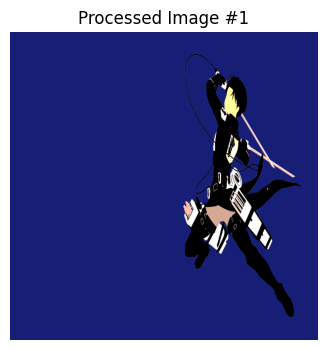

In [ ]:
import os
import time
import torch
import psutil
import warnings
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
import pynvml

warnings.filterwarnings("ignore")

# -------------------------------
# RAM and GPU memory usage
# -------------------------------
def print_peak_ram_usage():
    process = psutil.Process(os.getpid())
    print(f"Peak RAM Usage: {process.memory_info().rss / (1024 ** 2):.2f} MB")

def print_gpu_memory_usage():
    pynvml.nvmlInit()
    h = pynvml.nvmlDeviceGetHandleByIndex(0)
    mem = pynvml.nvmlDeviceGetMemoryInfo(h)
    print(f"GPU Memory Used: {mem.used / 1024**2:.2f} MB")
    print(f"GPU Memory Total: {mem.total / 1024**2:.2f} MB")

# -------------------------------
# Image preprocessing on GPU
# -------------------------------
def preprocess_image_torch_gpu(image_path, target_size=(1080, 1080), to_gray=False, device="cuda"):
    img = Image.open(image_path)

    if to_gray:
        img = img.convert("L")
        transform = T.Compose([
            T.Resize(target_size, interpolation=T.InterpolationMode.LANCZOS),
            T.ToTensor(),
            T.Lambda(lambda x: (x - x.mean()) / (x.std() + 1e-8))
        ])
    else:
        img = img.convert("RGB")
        transform = T.Compose([
            T.Resize(target_size, interpolation=T.InterpolationMode.LANCZOS),
            T.ToTensor(),
            T.Lambda(lambda x: (x - x.mean()) / (x.std() + 1e-8))
        ])

    img_tensor = transform(img).to(device)
    return img_tensor

# -------------------------------
# Run pipeline on folder
# -------------------------------
def run_pipeline_on_folder_torch_gpu(folder_path, to_gray=False):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not image_files:
        print("No image files found.")
        return

    print(f"Found {len(image_files)} image(s) in: {folder_path}")

    total_bytes = 0
    processed = []

    start = time.time()
    for f in image_files:
        tensor = preprocess_image_torch_gpu(os.path.join(folder_path, f), to_gray=to_gray, device=device)
        processed.append(tensor)
        total_bytes += tensor.numel() * tensor.element_size() * 2  # read + processed
    torch.cuda.synchronize()
    end = time.time()

    elapsed = end - start
    bandwidth = total_bytes / elapsed / 1e9

    print(f"\nProcessed {len(processed)} image(s)")
    print(f"Total Execution Time: {elapsed:.4f} seconds")
    print(f"Estimated Memory Bandwidth: {bandwidth:.3f} GB/s")
    print_peak_ram_usage()
    print_gpu_memory_usage()

    for i, img_tensor in enumerate(processed[:2]):
        img_np = img_tensor.detach().cpu().numpy()
        plt.figure(figsize=(4, 4))
        if img_np.shape[0] == 1:
            plt.imshow(img_np[0], cmap='gray')
        else:
            plt.imshow(img_np.transpose(1, 2, 0))
        plt.axis('off')
        plt.title(f"Processed Image #{i}")
        plt.show()


# -------------------------------
# Example Usage
# -------------------------------
folder = "/content/gdrive/MyDrive/Colab Notebooks/MSML605 Project/images"
run_pipeline_on_folder_torch_gpu(folder, to_gray=False)


#### 3. C++

In [ ]:
## kaggle